CLEMnet: Training the model
====================

This notebook is used to train CLEMnet. 

It is divided into 3 parts:
- Initialising (importing packages, setting up GPU environment, selecting datasets, etc.)
- DataGenerators (set up data generators for training and validation)
- Training (define metrics, loss, etc.)

________________
Initialising
---------

- Importing all desired packages. 
- Setting up GPU and CPU environment. 
- Initialising general variables. 
- Select training datasets.

In [1]:
##### Libary #####
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import datetime

##### Import self-written functions #####
import clem_net as clem

%matplotlib inline

In [2]:
##### GPU setup #####
os.environ["CUDA_VISIBLE_DEVICES"]="2"    #chose which GPU to use (0-3)

##### CPU setup #####
os.environ['MKL_NUM_THREADS'] = '20'     #chose the amount of CPUs to use, idk if this is working right now?
os.environ['GOTO_NUM_THREADS'] = '20'    #however, maybe works if GPU is not present/working
os.environ['OMP_NUM_THREADS'] = '20'
os.environ['openmp'] = 'True'

In [3]:
##### General variables #####
training_dir = '/home/rlane/FMML_DATA/20200618_RL012/2us/'     #directory to find trainable tiles
EM_tile_size = 1024     #size in pixels of 1 EM tile
FM_tile_size = 1024     #size in pixels of 1 FM tile
EMFM_lvl_d = 5          #difference in scale between EM and FM
augmen = True           #augmentation on (True) or off (False)

clem.variables(training_dir, EM_tile_size, FM_tile_size, EMFM_lvl_d, augmen)

##### Name of this particular run #####
run_name = '134910_insulin_2us'

General variables loaded


In [5]:
##### Locate all datasets #####
#DNA/RNA (hoechst)
section_subfolders = [{"EM": "lil_EM_2us_montaged/1/", "FM": "hoechst_correlated/1/"},    #0 (folder number)
                    {"EM": "lil_EM_2us_montaged/3/", "FM": "hoechst_correlated/3/"},    #1
                    {"EM": "lil_EM_2us_montaged/4/", "FM": "hoechst_correlated/4/"},    #2
                    {"EM": "lil_EM_2us_montaged/7/", "FM": "hoechst_correlated/7/"},    #3
                    {"EM": "lil_EM_2us_montaged/9/", "FM": "hoechst_correlated/9/"},    #4
                    {"EM": "lil_EM_2us_montaged/10/", "FM": "hoechst_correlated/10/"}]   #5
#Insulin (Alexa495)
section_subfolders = [{"EM": "lil_EM_2us_montaged/1/", "FM": "insulin_correlated/1/"}, 
                    {"EM": "lil_EM_2us_montaged/3/", "FM": "insulin_correlated/3/"},
                    {"EM": "lil_EM_2us_montaged/4/", "FM": "insulin_correlated/4/"},
                    {"EM": "lil_EM_2us_montaged/7/", "FM": "insulin_correlated/7/"},
                    {"EM": "lil_EM_2us_montaged/9/", "FM": "insulin_correlated/9/"},
                    {"EM": "lil_EM_2us_montaged/10/", "FM": "insulin_correlated/10/"}]

##### Deselect test dataset(s) #####
test_folder = [3]
for i in reversed(test_folder):
    section_subfolders.pop(i)
print('Training will be performed on data sets:')
for x in section_subfolders:
    print(x)

Training will be performed on data sets:
{'EM': 'lil_EM_2us_montaged/1/', 'FM': 'insulin_correlated/1/'}
{'EM': 'lil_EM_2us_montaged/3/', 'FM': 'insulin_correlated/3/'}
{'EM': 'lil_EM_2us_montaged/4/', 'FM': 'insulin_correlated/4/'}
{'EM': 'lil_EM_2us_montaged/9/', 'FM': 'insulin_correlated/9/'}
{'EM': 'lil_EM_2us_montaged/10/', 'FM': 'insulin_correlated/10/'}


___________________

Set up DataGenerator
---------
During training, data (images) need to be delivered to the model. The next few cells set up the architecture which calls and prepares data before it can be learned on.

- `sections` variable is created in order to easily handle images from different directories.
- Training and validation images are determined. A fraction of `val_size` of the total trainable image becomes validation images. From now on, a training images will be called training patch.
- A training DataGenerator is set up which will call and handle training patches. The training DataGenerator will present training patches in batches to the network.
- A validation DataGenerator is set up, which will call the validation patches.

In [6]:
##### Combines all functions concerning patches into one class #####
sections = clem.getSectionList(section_subfolders, clem.training_dir)

Patches located and all functions related to patches initialized


In [7]:
#### Setup DataGenerator #####

## DataGenerator parameters
batch_size_1 = 16                #max GPU can handle (GPU = Tesla 40C, 12198MB storage?)
n_gpu = 1                        #number of GPUs
batch_size = batch_size_1*n_gpu  #total batch size
val_size = 0.1                   #fraction of training data used for validation, set to negative to only pick one patch
one_patch_state = False         #no need to be called right?
n_folder = len(section_subfolders) #number of training directories

## Possibility to train on one patch only
if val_size < 0:
    'set parameters to train on only 1 patch'
    one_patch_state = True
    N_patch = len(sections[0].sectionXYList)    #total number of patches
    val_size = 1-1/N_patch                  #validation fraction to maximum, leaves one patch to be trained on
    batch_size = 1
    n_gpu = 1
rand_state = 2                      #used to select certain images

## Initialize DataGenerators
training_generator = clem.DataGenerator_NonRand(sections, batch_size, val_size, rand_state, n_folder, training=True)
validation_generator = clem.DataGenerator_NonRand(sections, batch_size, val_size, rand_state, n_folder, training=False)

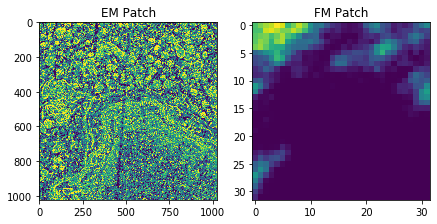

In [9]:
## Show a EM image and corresponding FM image
test_batch = training_generator.__getitem__(4)
im_EM_patch = test_batch[0][0]
im_FM_patch = test_batch[1][0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,7))
ax1.imshow(im_EM_patch[:,:,0])
ax1.set_title('EM Patch')
ax2.imshow(im_FM_patch[:,:,0])
ax2.set_title('FM Patch')
plt.show()

## Note: Running this cell will (randomly) result in rotated and flipped versions of the original patch due to augmentation methods

________________
Training CLEM-net
------

Here, model is trained for a set number of epochs. Every epoch, training has been done on all training patches in a random order. Loss, Pearson correlation and Accuracy are determined after every batch. After every epoch, model is validated on validation patches. If validation loss for the last epoch is lower than the lowest validation loss uptill latest epoch, model weights are saved.

There is a possibility to save the whole model after all epochs to proceed training a later time. Therefore, weights can also be loaded into the model before learning to proceed to training an already learned model.

In [10]:
##### set up metrics #####
def acc_pred(y_true, y_pred):
    'accuracy metric as described in progress report'
    a = (1-abs(y_true-y_pred))
    b = keras.backend.sum(a)/(32*32)/batch_size
    return b

def time_epoch(y_true, y_pred):
    'time epoch run time'
    return timeit.default_timer()-time_start

def pearson(y_true, y_pred):
    'pearson correlation coefficient'
    x0 = y_true-K.mean(y_true)
    y0 = y_pred-K.mean(y_pred) 
    return K.sum(x0*y0) / K.sqrt(K.sum((x0)**2)*K.sum((y0)**2))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('weights/' + run_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True,
                                   save_weights_only=True, save_freq='epoch')   #condition to save weihts if val_loss is lowest

logdir = os.path.join("logs", run_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))   #use tensorboard for visulization
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1, profile_batch=0)

In [11]:
##### Tensorboard #####

# %load_ext tensorboard
# %tensorboard --logdir logs --port 6007
# %tensorboard --logdir logs --host "127.0.0.1" --port 16006

In [12]:
#### Training setting #####
epochs = 160    #amount of epochs
verbose = 1    #print output while training
lr = 1e-5      #learning rate

##### load model #####
with tf.device('/cpu:0'):
    model = clem.getModel()
parallel_model = model
parallel_model.compile(optimizer = keras.optimizers.Adam(lr = lr), 
                       loss=keras.losses.BinaryCrossentropy(),
                       metrics = [acc_pred, pearson])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [13]:
##### Load model weights #####
## Run to proceed to learn an already existing network 
# weight_name = '00_getmodel_samekernel_134910'
# name_weight = "weights/" + weight_name + ".h5"
# model.load_weights(name_weight)


In [ ]:
##### Train model #####

## Training on only one patch
if one_patch_state == True:
    parallel_model.fit_generator(generator=training_generator, 
                             epochs=epochs, 
                             verbose=verbose, 
                             callbacks=[tensorboard_callback])
## Training on all training images
if one_patch_state == False:
    parallel_model.fit_generator(generator=training_generator, 
                             validation_data = validation_generator,
                             epochs=epochs, 
                             verbose=verbose,
                             callbacks=[tensorboard_callback, model_checkpoint])
    
##### Save model #####
filename = datetime.datetime.now().strftime("%Y%m%d_%H%M")+run_name+"_"+str(epochs)+".h5"
model.save_weights('weights/'+filename)
print("Model saved as: "+filename)


Epoch 1/160
353/354 [============================>.] - ETA: 1s - loss: 0.2391 - acc_pred: 0.9036 - pearson: 0.2621
Epoch 00001: val_loss improved from inf to 0.19768, saving model to weights/134910_insulin_2us.h5
354/354 [==============================] - 549s 2s/step - loss: 0.2390 - acc_pred: 0.9037 - pearson: 0.2624 - val_loss: 0.1977 - val_acc_pred: 0.9177 - val_pearson: 0.4886
Epoch 2/160
353/354 [============================>.] - ETA: 1s - loss: 0.2112 - acc_pred: 0.9197 - pearson: 0.4481
Epoch 00002: val_loss improved from 0.19768 to 0.19070, saving model to weights/134910_insulin_2us.h5
354/354 [==============================] - 548s 2s/step - loss: 0.2110 - acc_pred: 0.9198 - pearson: 0.4485 - val_loss: 0.1907 - val_acc_pred: 0.9244 - val_pearson: 0.5350
Epoch 3/160
353/354 [============================>.] - ETA: 1s - loss: 0.2052 - acc_pred: 0.9227 - pearson: 0.4706
Epoch 00003: val_loss improved from 0.19070 to 0.19020, saving model to weights/134910_insulin_2us.h5
354/354 [